In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Mental rotation

In this notebook we will show how we can enable a pretrained Generative Query Network (GQN) for the Shepard-Metzler mental rotation task. The problem is well studied in psychology to asses spatial intelligence. Mental rotation is a congitive hard problem as it typically requires the employment of both the ventral and dorsal visual streams for recognition and spatial reasoning respectively. Additionally, a certain degree of metacognition is required to reason about uncertainty.

It turns out that the GQN is capable of this, as we will see in this notebook.

<div class="alert alert-block alert-danger">
<strong>Note:</strong>
This model has only been trained on around 10% of the data for $2 \times 10^5$ iterations instead of the $2 \times 10^6$ described in the original paper. This means that the reconstructions are quite bad and the samples are even worse. Consequently, this notebook is just a proof of concept that the model approximately works. If you have the computational means to fully train the model, then please feel free to make a pull request with the trained model, this will help me a lot.
</div>

You can download the pretrained model weights from here: [https://github.com/wohlert/generative-query-network-pytorch/releases/tag/0.1](https://github.com/wohlert/generative-query-network-pytorch/releases/download/0.1/model-checkpoint.pth).

In [2]:
import torch
import torch.nn as nn
    
# Load dataset
from shepardmetzler import ShepardMetzler
from torch.utils.data import DataLoader

dataset = ShepardMetzler("/home/mila/c/chahinen/scratch/Data/gqndata_converted_rooms/rooms_free_camera_with_object_rotations") ## <= Choose your data location
loader = DataLoader(dataset, batch_size=1, shuffle=True)

We load a batch of a single image containing a single object seen from 15 different viewpoints. We describe the whole set of image, viewpoint pairs by $\{x_i, v_i \}_{i=1}^{n}$. Whereafter we seperate this set into a context set $\{x_i, v_i \}_{i=1}^{m}$ of $m$ random elements and a query set $\{x^q, v^q \}$, which contains just a single element.

In [3]:
from gqn import GenerativeQueryNetwork
from gqn.training import partition
import torch
import torch.nn as nn # You may need to import nn

# Load the entire checkpoint dictionary from the file
checkpoint = torch.load("/home/mila/c/chahinen/scratch/gqn_logs/rooms_batch16/checkpoint_checkpoint_19882.pt", map_location="cpu")

# --- FIX: Extract just the model's state dictionary ---
# The actual parameters are stored under the 'model' key
state_dict = checkpoint['model']

# Initialise new model with the settings of the trained one
model_settings = dict(x_dim=3, v_dim=7, r_dim=256, h_dim=128, z_dim=64, L=8)
model = GenerativeQueryNetwork(**model_settings)

# Load trained parameters, un-dataparallel if needed
if True in ["module" in m for m in list(state_dict.keys())]:
    model = nn.DataParallel(model)
    model.load_state_dict(state_dict)
    model = model.module
else:
    # Now this line will work correctly because you are passing the right dictionary
    model.load_state_dict(state_dict) 
    
model

/tmp/ipykernel_727046/1733154433.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/mila/c/chahinen/scratch/gqn_logs/rooms_batch16/checkpoint

GenerativeQueryNetwork(
  (generator): GeneratorNetwork(
    (inference_core): Conv2dLSTMCell(
      (forget): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (input): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (output): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (state): Conv2d(394, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (transform): Conv2d(128, 394, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (generator_core): Conv2dLSTMCell(
      (forget): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (input): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (output): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (state): Conv2d(327, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (transform): Conv2d(128, 327, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (posterio

In [4]:
def deterministic_partition(images, viewpoints, indices):
    """
    Partition batch into context and query sets.
    :param images
    :param viewpoints
    :return: context images, context viewpoint, query image, query viewpoint
    """
    # Maximum number of context points to use
    _, b, m, *x_dims = images.shape
    _, b, m, *v_dims = viewpoints.shape

    # "Squeeze" the batch dimension
    images = images.view((-1, m, *x_dims))
    viewpoints = viewpoints.view((-1, m, *v_dims))

    # Partition into context and query sets
    context_idx, query_idx = indices[:-1], indices[-1]

    x, v = images[:, context_idx], viewpoints[:, context_idx]
    x_q, v_q = images[:, query_idx], viewpoints[:, query_idx]

    return x, v, x_q, v_q

/home/mila/c/chahinen/gqn_project/generative-query-network-pytorch/shepardmetzler.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(f)


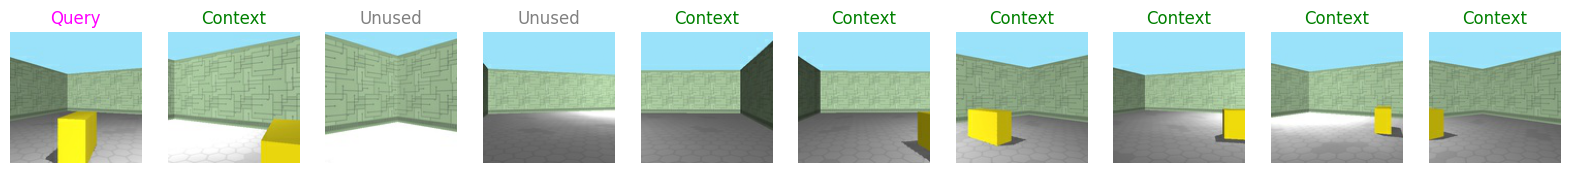

In [5]:
import random
import matplotlib.pyplot as plt

# The number of views in the Rooms dataset is 10
num_views = 10 

# Pick a scene to visualise
scene_id = 0

# Load data (assuming 'loader' is your DataLoader)
x, v = next(iter(loader))
# Remove the extra batch dimension that the loader might add
x_, v_ = x.squeeze(0), v.squeeze(0)

# Sample a set of views
n_context = 7 + 1
# Ensure the number of views is correct for random sampling
indices = random.sample([i for i in range(v_.size(1))], n_context)

# Seperate into context and query sets
# (Assuming you have a 'deterministic_partition' function defined)
x_c, v_c, x_q, v_q = deterministic_partition(x, v, indices)

# --- CORRECTED VISUALIZATION ---
# Create a plot with 10 subplots to match the data
f, axarr = plt.subplots(1, num_views, figsize=(20, 7))
for i, ax in enumerate(axarr.flat):
    # Move channel dimension to end for plotting
    ax.imshow(x_[scene_id][i].permute(1, 2, 0))
    
    if i == indices[-1]:
        ax.set_title("Query", color="magenta")
    elif i in indices[:-1]:
        ax.set_title("Context", color="green")
    else:
        ax.set_title("Unused", color="grey")
    
    ax.axis("off")

plt.show()

## Reconstruction

Now we feed the whole set into the network and the network will perform the segregration of sets. The query image is then reconstructed in accordance to a given viewpoint and a representation vector that has been generated only by the context set.

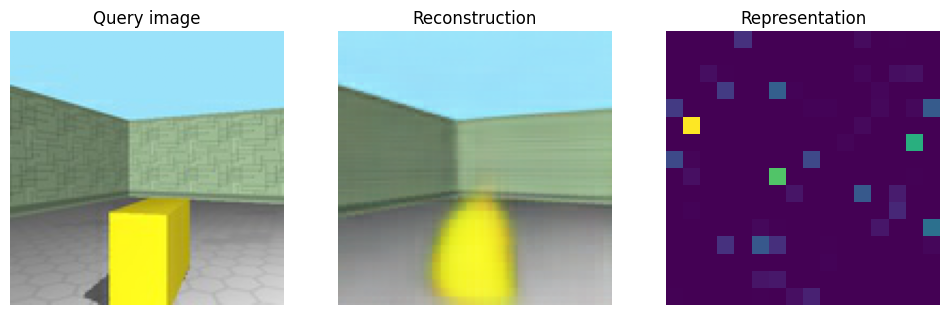

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 7))

x_mu, r, kl = model(x_c[scene_id].unsqueeze(0), 
                    v_c[scene_id].unsqueeze(0), 
                    x_q[scene_id].unsqueeze(0),
                    v_q[scene_id].unsqueeze(0))

x_mu = x_mu.squeeze(0)
r = r.squeeze(0)

ax1.imshow(x_q[scene_id].data.permute(1, 2, 0))
ax1.set_title("Query image")
ax1.axis("off")

ax2.imshow(x_mu.data.permute(1, 2, 0))
ax2.set_title("Reconstruction")
ax2.axis("off")

ax3.imshow(r.data.view(16, 16))
ax3.set_title("Representation")
ax3.axis("off")

plt.show()

## Visualising representation

We might be interested in visualising the representation as more context points are introduced. The representation network $\phi(x_i, v_i)$ generates a single representation for a context point $(x_i, v_i)$ which is then aggregated (summed) for each context point to generate the final representation.

Below, we see how adding more context points creates a less sparse representation.

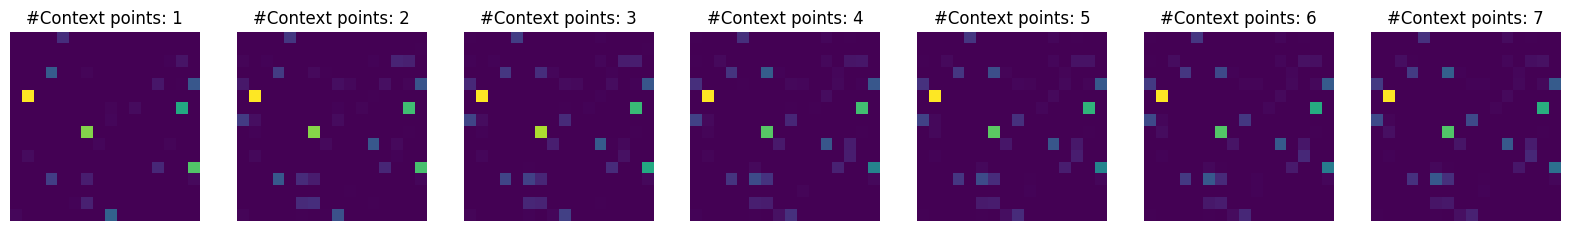

In [7]:
f, axarr = plt.subplots(1, 7, figsize=(20, 7))

# We will initialize 'r' on the first loop iteration to ensure it has the correct shape
r_cumulative = None 
# A variable to select which item from the batch to visualize
scene_id = 0

for i, ax in enumerate(axarr.flat):
    # Calculate the representation for the current context view
    # Note: You may need to provide your context variables x_c and v_c here
    with torch.no_grad(): # Use no_grad for inference
        phi = model.representation(x_c[:, i], v_c[:, i])

    if r_cumulative is None:
        # On the first iteration, create r_cumulative with the same shape as phi
        r_cumulative = torch.zeros_like(phi)
    
    # Now the shapes match, and the addition will work
    r_cumulative += phi 

    ax.imshow(r_cumulative[scene_id].data.view(16, 16))
    ax.axis("off")
    ax.set_title("#Context points: {}".format(i+1))

plt.show()

## Sample from the prior.

Because we use a conditional prior density $\pi(z|y)$ that is parametrised by a neural network, we should be able to continuously refine it during training such that if $y = (v, r)$ we can generate a sample from the data distrbution by sampling $z \sim \pi(z|v,r)$ and sending it through the generative model $g_{\theta}(x|z, y)$.

This means that we can give a number of context points along with a query viewpoint and generate a new image.

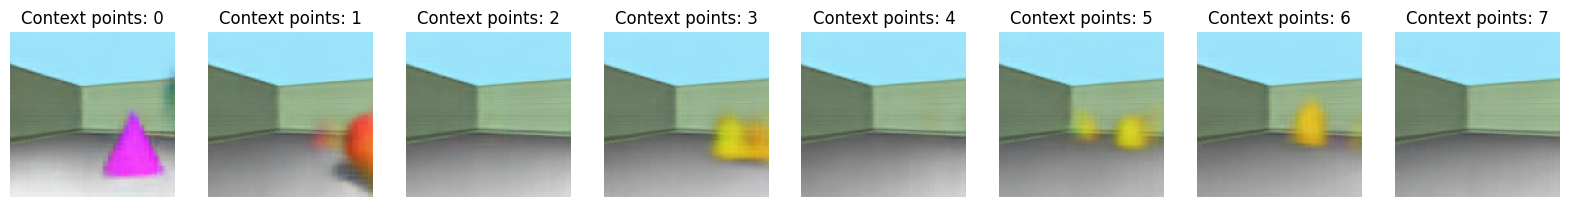

In [8]:
# Create progressively growing context set
batch_size, n_views, c, h, w = x_c.shape
num_samples = 8
f, axarr = plt.subplots(1, num_samples, figsize=(20, 7))
for i, ax in enumerate(axarr.flat):
    x_ = x_c[scene_id][:i+1].view(-1, c, h, w)
    v_ = v_c[scene_id][:i+1].view(-1, 7)
    
    phi = model.representation(x_, v_)
    
    r = torch.sum(phi, dim=0)
    x_mu = model.generator.sample((h, w), v_q[scene_id].unsqueeze(0), r)
    ax.imshow(x_mu.squeeze(0).data.permute(1, 2, 0))
    ax.set_title("Context points: {}".format(i))
    ax.axis("off")
plt.show()

## Mental rotation task

As an extension to the above mentioned sampling procedure, we can perform the mental rotation task by continuously sampling from the prior given a static representation $r$ and then varying the query viewpoint vector $v^q$ between each sample to "rotate the object".

In the example below we change the yaw slightly at each frame for 8 frames.

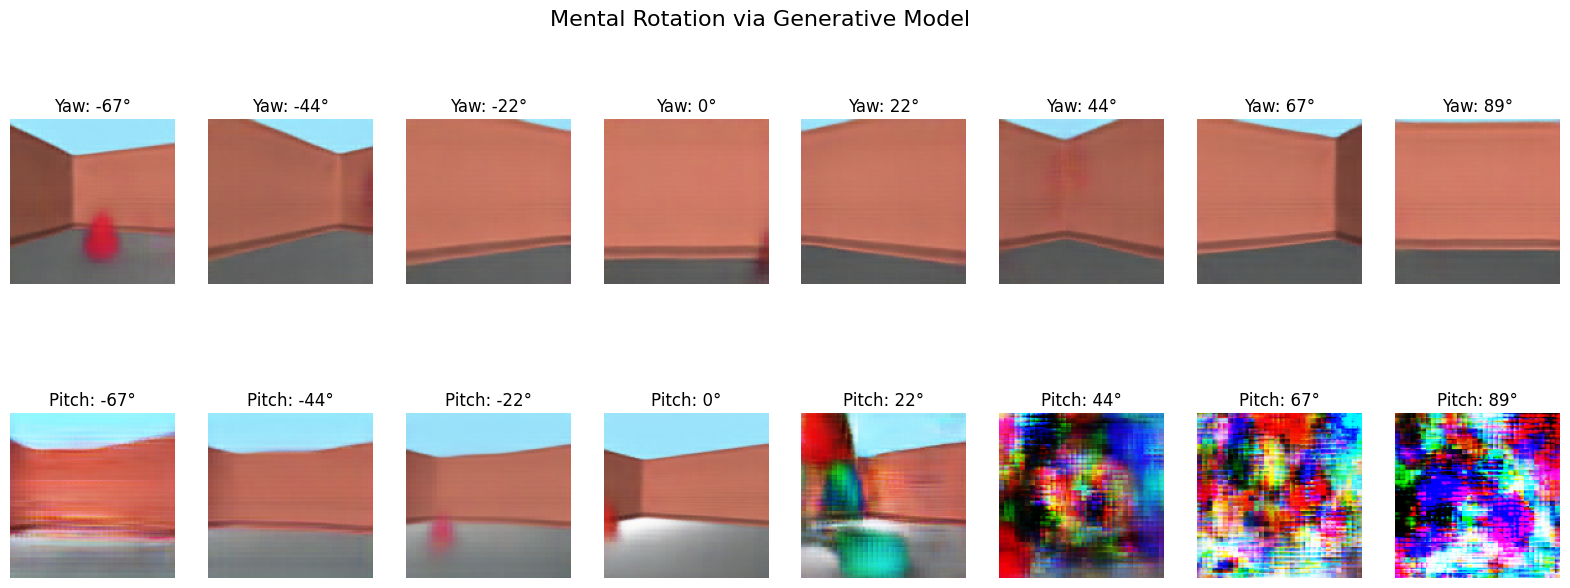

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- Preparation Code ---

num_samples = 8
scene_id = 0 

# Load a batch of data from the DataLoader
x, v = next(iter(loader))

# The DataLoader adds an extra dimension of size 1 at the beginning. We remove it.
x = x.squeeze(0)
v = v.squeeze(0)

# Partition the data into context and query sets
context_x, context_v, query_x, query_v = partition(x, v)

# --- THIS IS THE FIX ---
# The original partition() function removes the 'views' dimension from the query.
# We add it back here. Shape changes from (batch, 7) to (batch, 1, 7).
query_v = query_v.unsqueeze(1)
# --- END FIX ---


# This loop ensures the query set is not empty (it should now always have size 1)
while query_v.shape[1] == 0:
    print("Re-partitioning data: Query set was empty.")
    context_x, context_v, query_x, query_v = partition(x, v)
    query_v = query_v.unsqueeze(1) # Apply fix inside loop too


# --- Plotting Code ---

pi = 3.1415629

# Generate the scene representation 'r'
with torch.no_grad():
    batch_size, n_context, c, h, w = context_x.shape
    
    x_context_flat = context_x.reshape(-1, c, h, w)
    v_context_flat = context_v.reshape(-1, 7)
    
    model.to(x_context_flat.device)
    phi = model.representation(x_context_flat, v_context_flat)
    
    phi = phi.view(batch_size, n_context, -1)
    r_batch = torch.sum(phi, dim=1)
    
    r = r_batch[scene_id]
    r = r.unsqueeze(-1).unsqueeze(-1)


# Create the plot
f, axarr = plt.subplots(2, num_samples, figsize=(20, 7))
f.suptitle("Mental Rotation via Generative Model", fontsize=16)

# --- Animate Yaw ---
for i, ax in enumerate(axarr[0].flat):
    # Now query_v[scene_id, 0] will work correctly
    v_new = query_v[scene_id, 0].clone()
    
    yaw = (i+1) * (pi/8) - pi/2
    v_new[3], v_new[4] = np.cos(yaw), np.sin(yaw)

    with torch.no_grad():
        x_mu = model.generator.sample((h, w), v_new.unsqueeze(0), r.unsqueeze(0))
        
    ax.imshow(x_mu.squeeze(0).data.permute(1, 2, 0))
    ax.set_title(r"Yaw: " + f"{int(np.degrees(yaw))}°")
    ax.axis("off")
    
# --- Animate Pitch ---
for i, ax in enumerate(axarr[1].flat):
    v_new = query_v[scene_id, 0].clone()
    
    pitch = (i+1) * (pi/8) - pi/2
    v_new[5], v_new[6] = np.cos(pitch), np.sin(pitch)

    with torch.no_grad():
        x_mu = model.generator.sample((h, w), v_new.unsqueeze(0), r.unsqueeze(0))
        
    ax.imshow(x_mu.squeeze(0).data.permute(1, 2, 0))
    ax.set_title(r"Pitch: " + f"{int(np.degrees(pitch))}°")
    ax.axis("off")

plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# This should be the path to the directory containing the 'train' and 'test' folders
data_path = "/home/mila/c/chahinen/scratch/Data/gqndata_converted_rooms/rooms_free_camera_with_object_rotations"

# --- 1. SETUP ---
print("Setting up for place cell analysis...")

# --- Tunable Parameters ---
BINS = 16
UNITS_TO_PLOT = [10, 25, 50, 75, 100, 125, 150, 200]
POS_RANGE = (-4, 4)

# Ensure the model is in evaluation mode
model.eval()

# Create a DataLoader for the test set
try:
    # The ShepardMetzler class correctly finds the 'test' subdirectory
    test_dataset = ShepardMetzler(data_path, train=False, fraction=0.01)
    # batch_size=None is not a standard PyTorch argument, so we use batch_size=1
    # and then squeeze the dimension, which is a more robust pattern.
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    print(f"Loaded test dataset. Total batches: {len(test_loader)}")
except Exception as e:
    print(f"Could not load test dataset. Error: {e}")
    
# Get representation dimension from the model
r_dim = model.representation.r_dim
activations_grid = np.zeros((r_dim, BINS, BINS))
counts_grid = np.zeros((BINS, BINS))

# --- 2. DATA COLLECTION LOOP ---
print("Processing test dataset to gather activations...")
with torch.no_grad():
    for x, v in test_loader:
        # --- THIS IS THE FIX ---
        # The DataLoader with batch_size=1 adds an extra dimension of size 1.
        # We remove it here to get the correct 5D shape: (Batch, Views, C, H, W)
        x = x.squeeze(0)
        v = v.squeeze(0)
        # --- END FIX ---
        
        context_x, context_v, _, _ = partition(x, v)

        # Now context_x is 5D, and this unpacking will work
        batch_size, n_context, c, h, w = context_x.shape
        
        x_context_flat = context_x.reshape(-1, c, h, w)
        # Assuming viewpoint dimension is 7
        v_context_flat = context_v.reshape(-1, 7)
        
        # Ensure data and model are on the same device
        model.to(x_context_flat.device)
        phi = model.representation(x_context_flat, v_context_flat)
        
        phi = phi.view(batch_size, n_context, -1)
        r = torch.sum(phi, dim=1).cpu().numpy()

        avg_pos = torch.mean(context_v[:, :, :2], dim=1).cpu().numpy()
        
        internal_batch_size = r.shape[0]
        for i in range(internal_batch_size):
            x_pos, y_pos = avg_pos[i]
            x_norm = (x_pos - POS_RANGE[0]) / (POS_RANGE[1] - POS_RANGE[0])
            y_norm = (y_pos - POS_RANGE[0]) / (POS_RANGE[1] - POS_RANGE[0])
            
            x_bin = np.clip(int(x_norm * BINS), 0, BINS - 1)
            y_bin = np.clip(int(y_norm * BINS), 0, BINS - 1)
            
            activations_grid[:, y_bin, x_bin] += r[i]
            counts_grid[y_bin, x_bin] += 1

print("Finished processing dataset.")

# --- 3. CALCULATE AVERAGE ACTIVATIONS & 4. PLOTTING ---
counts_grid[counts_grid == 0] = 1 # Avoid division by zero
avg_activations = activations_grid / counts_grid

print("Generating plots...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Place Cell Activations in Representation Layer", fontsize=16)

for i, unit_idx in enumerate(UNITS_TO_PLOT):
    ax = axes.flat[i]
    # Use a perceptually uniform colormap like 'viridis' or 'plasma'
    im = ax.imshow(avg_activations[unit_idx], cmap='viridis', origin='lower')
    ax.set_title(f'Unit {unit_idx}')
    ax.set_xticks([])
    ax.set_yticks([])

# Add a colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, label="Average Activation")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Setting up for place cell analysis...
Loaded test dataset. Total batches: 197
Processing test dataset to gather activations...


Generating plots...


/tmp/ipykernel_2756348/1919170893.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


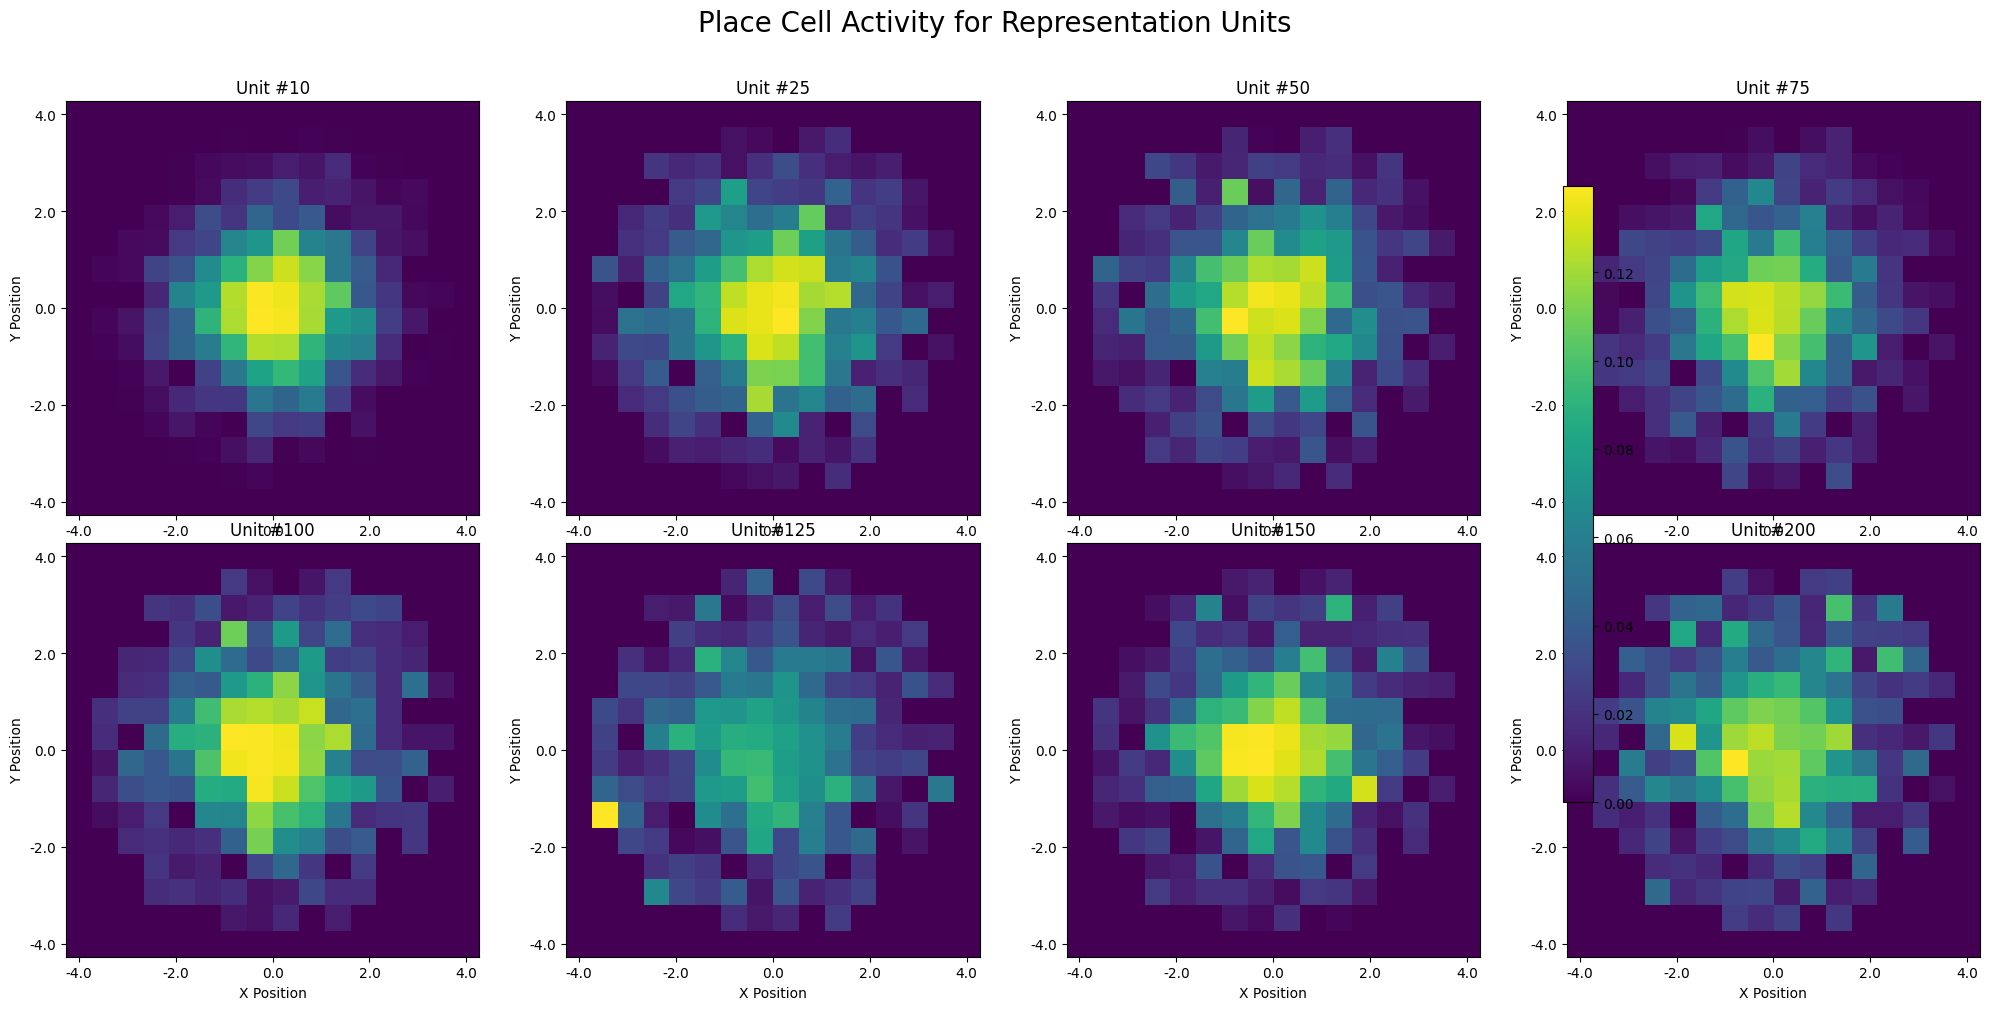

In [19]:
# --- 4. PLOTTING ---
print("Generating plots...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Place Cell Activity for Representation Units", fontsize=20)

for i, unit_idx in enumerate(UNITS_TO_PLOT):
    ax = axes.flat[i]
    
    # Extract the 2D "place field" for the current neuron
    place_field = avg_activations[unit_idx]
    
    im = ax.imshow(place_field, cmap='viridis', origin='lower')
    ax.set_title(f"Unit #{unit_idx}")
    ax.set_xticks(np.linspace(0, BINS-1, 5))
    ax.set_yticks(np.linspace(0, BINS-1, 5))
    ax.set_xticklabels(np.linspace(POS_RANGE[0], POS_RANGE[1], 5))
    ax.set_yticklabels(np.linspace(POS_RANGE[0], POS_RANGE[1], 5))
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")

# Add a single colorbar for all subplots
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()